# Predicting the time until a stock increases by 5%
High yields savings accounts have offered yearly returns between 4% and 5%. Is there a strategy with stocks that can outperform this by consistently yielding 5% returns sooner than a year? To answer this, we would have to predict how long it will take a particular stock to increase by 5%.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

## Posing the problem as time-invariant regression, and not relying on price
One approach would be to forecast the price of the stock, and check when (if ever) a 5% return is predicted. There are several attempts online to do this, and the daily fluctuations pose a significant challenge. The goal here is much simpler since we can just focus outputs that predict quick returns. So, we will generate some time-invariant features to forecast days until a 5% return.



## Data Exploration
We will focus on the closing price to track the percentage increase.

In [2]:
mcd = yf.Ticker('MCD')
mcd_df = mcd.history(period='5y', interval='1d')
mcd_df.reset_index(inplace=True)

In [3]:
mcd_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-11-21 00:00:00-05:00,172.975123,173.313457,171.176634,171.256775,3509500,0.0,0.0
1,2019-11-22 00:00:00-05:00,172.004679,172.209453,171.078718,171.960159,2417700,0.0,0.0
2,2019-11-25 00:00:00-05:00,172.672366,173.010699,170.588976,170.847168,3999600,0.0,0.0
3,2019-11-26 00:00:00-05:00,170.945149,172.752537,170.900629,172.734726,3877200,0.0,0.0
4,2019-11-27 00:00:00-05:00,172.957336,175.103057,172.654624,174.773636,4133000,0.0,0.0


### Calculating time to 5% increase
1. Calculate the price for a 5% increase.
2. Find the first date that happens, if any.
3. Calculate differences in the dates.

In [4]:
mcd_df['increase_5p_price'] = mcd_df['Close']*1.05
for ind, row in mcd_df.iterrows():
    row_date = row['Date']
    mcd_df.loc[ind, 'increase_5p_date'] = next(
        (row_['Date'] for _, row_ in mcd_df.query(
            'Date > @row_date'
        ).iterrows() if row_['Close'] > row['increase_5p_price']),
        None
    )
mcd_df['increase_5p_days'] = (mcd_df['increase_5p_date'] - mcd_df['Date']).dt.days

Looking at the overall statistics of time to increase, and also comparing by year, it seems like it could be likely to expect a 5% percent sooner than a year. There are times where it takes longer, and we would like to purchase when it would take the least time to increase to 5%. Looking at the raw data, it doesn't seem easy to predict.

In [5]:
mcd_df['increase_5p_days'].describe()

count    1219.000000
mean      104.945037
std       112.942214
min         1.000000
25%        25.000000
50%        62.000000
75%       138.500000
max       518.000000
Name: increase_5p_days, dtype: float64

In [6]:
mcd_df.groupby(
    mcd_df['Date'].dt.year
)['increase_5p_days'].describe()

,count,mean,std,min,25%,50%,75%,max
Date,,,,,,,,
2019,27.0,27.925926,10.662392,9.0,20.50,28.0,36.5,45.0
2020,253.0,85.505929,80.634666,1.0,16.00,41.0,161.0,240.0
2021,252.0,71.242063,73.713406,4.0,33.00,53.0,77.0,324.0
2022,251.0,92.099602,77.702574,2.0,28.50,82.0,131.5,445.0
2023,250.0,175.728000,176.036090,10.0,27.25,84.0,283.5,518.0
2024,186.0,110.424731,88.965935,4.0,27.25,96.5,203.5,285.0


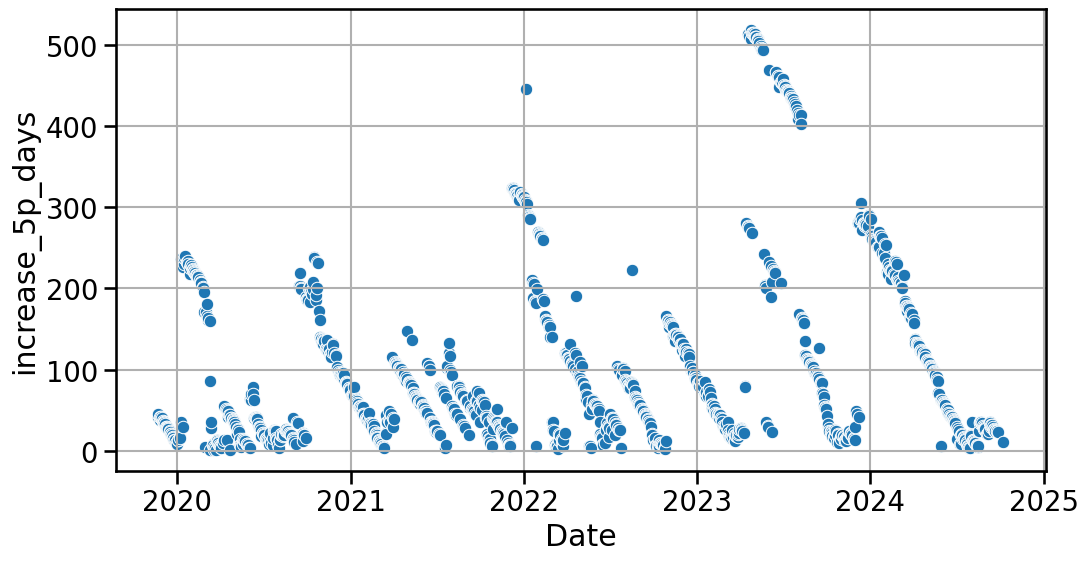

In [7]:
with sns.plotting_context('talk', font_scale=1.2):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=mcd_df, x='Date', y='increase_5p_days')
    plt.grid()
    plt.show()

## Feature Engineering
### Time-related features
- day of year, quarter, year
### Previous year, and quarter statistics:
- time to increase, ytd, Closing price

In [8]:
mcd_df['day_of_year'] = mcd_df['Date'].dt.dayofyear
mcd_df['quarter'] = mcd_df['Date'].dt.quarter
mcd_df['year'] = mcd_df['Date'].dt.year
mcd_df['ytd_perc'] = mcd_df.groupby(
    'year'
).apply(
    lambda x: 100*(x['Close'] - x['Close'].iloc[0])/x['Close'].iloc[0],
    include_groups=False
).values

In [9]:
val_cols_for_prev_stats = ['increase_5p_days', 'ytd_perc', 'Close']
prev_year_mean_med_vals = mcd_df.groupby('year')[val_cols_for_prev_stats].agg(
    ['mean', 'median']
).reset_index().assign(
    year=lambda x: x['year'].shift(-1)
).dropna()
prev_year_mean_med_vals.columns = [
    'year', 'prev_year_inc_mean', 'prev_year_inc_median', 'prev_year_ytd_mean', 'prev_year_ytd_median',
    'prev_year_close_mean', 'prev_year_close_median'
]

In [10]:
prev_year_mean_med_vals

,year,prev_year_inc_mean,prev_year_inc_median,prev_year_ytd_mean,prev_year_ytd_median,prev_year_close_mean,prev_year_close_median
0,2020.0,27.925926,28.0,2.178691,2.210526,174.987930,175.042450
1,2021.0,85.505929,41.0,1.263164,4.172289,182.189561,187.423569
2,2022.0,71.242063,53.0,12.910038,12.930625,217.991128,218.030876
3,2023.0,92.099602,82.0,-4.532485,-4.876110,240.875645,240.008636
4,2024.0,175.728000,84.0,6.628341,7.847013,270.708656,273.802628


In [11]:
prev_year_quarter_mean_med_vals = mcd_df.groupby(['year', 'quarter'])[val_cols_for_prev_stats].agg(
    ['mean', 'median']
).reset_index().assign(
    year=lambda x: x['year'].shift(-4),
    quarter=lambda x: x['quarter'].shift(-4)
).dropna()
prev_year_quarter_mean_med_vals.columns = [
    'year', 'quarter', 'prev_y_q_inc_mean', 'prev_y_q_inc_median', 'prev_y_q_ytd_mean', 'prev_y_q_ytd_median',
    'prev_y_q_close_mean', 'prev_y_q_close_median'
]

In [12]:
train_test_df = mcd_df.merge(
    prev_year_mean_med_vals, how='left'
).merge(
    prev_year_quarter_mean_med_vals, how='left'
).bfill()
features_list = [
    'year', 'quarter', 'day_of_year',
    'prev_year_inc_mean', 'prev_year_inc_median', 'prev_year_ytd_mean', 'prev_year_ytd_median',
    'prev_year_close_mean', 'prev_year_close_median',
    'prev_y_q_inc_mean', 'prev_y_q_inc_median', 'prev_y_q_ytd_mean', 'prev_y_q_ytd_median',
    'prev_y_q_close_mean', 'prev_y_q_close_median'
]

In [13]:
train_test_df[features_list].tail()

,year,quarter,day_of_year,prev_year_inc_mean,prev_year_inc_median,prev_year_ytd_mean,prev_year_ytd_median,prev_year_close_mean,prev_year_close_median,prev_y_q_inc_mean,prev_y_q_inc_median,prev_y_q_ytd_mean,prev_y_q_ytd_median,prev_y_q_close_mean,prev_y_q_close_median
1253,2024,4,319,175.728,84.0,6.628341,7.847013,270.708656,273.802628,91.984127,23.0,4.893409,3.985391,266.304,263.998718
1254,2024,4,320,175.728,84.0,6.628341,7.847013,270.708656,273.802628,91.984127,23.0,4.893409,3.985391,266.304,263.998718
1255,2024,4,323,175.728,84.0,6.628341,7.847013,270.708656,273.802628,91.984127,23.0,4.893409,3.985391,266.304,263.998718
1256,2024,4,324,175.728,84.0,6.628341,7.847013,270.708656,273.802628,91.984127,23.0,4.893409,3.985391,266.304,263.998718
1257,2024,4,325,175.728,84.0,6.628341,7.847013,270.708656,273.802628,91.984127,23.0,4.893409,3.985391,266.304,263.998718


## Model Evaluation
Test on 2024, and train on the rest.

We can compare model accuracy with a simple of approach of just guessing the historical median time to 5% increase. The simple approach seems reasonable (and doesn't perform half bad) because the median time tends to be less than a year.

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
y_col = 'increase_5p_days'
train_slice = train_test_df.query('year < 2024').copy()
X_train = train_slice[features_list].copy()
y_train = train_slice[y_col].copy()
test_slice = train_test_df.query('year >= 2024').copy()
X_test = test_slice[features_list].copy()
y_test = test_slice[y_col].copy()

In [16]:
model = RandomForestRegressor(
    n_estimators=500, random_state=42,
    criterion='absolute_error',
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [17]:
err_df = pd.DataFrame({
    'pred': y_pred,
    'actual': y_test.values,
    'quarter': test_slice['quarter']
})
err_df['error'] = err_df['pred'] - err_df['actual']

In [18]:
pd.concat([
    err_df['error'].abs().describe().rename('rf_error'),
    (train_slice['increase_5p_days'].median() - y_test).abs().describe().rename('simple_model_error')
], axis=1)

,rf_error,simple_model_error
count,193.000000,193.000000
mean,36.328358,78.891192
std,24.559952,62.616837
min,0.641000,0.000000
25%,17.475000,34.000000
50%,35.800000,50.000000
75%,46.553000,141.000000
max,116.970000,225.000000


As seen above, the simple model is outperformed by the Random Forest model. Half the time, the predicted time to 5% is only off by one month. Below we could see the performance by quarter:

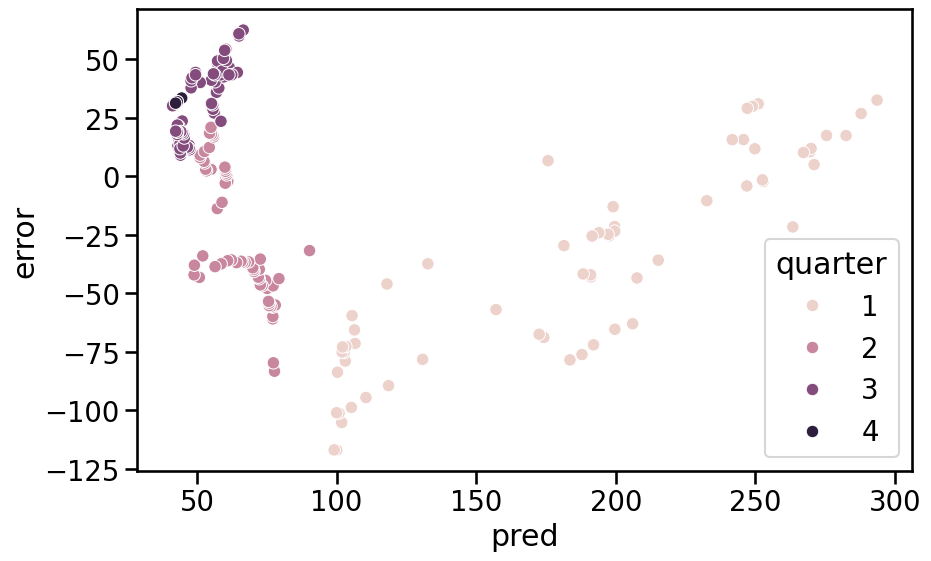

In [19]:
with sns.plotting_context('talk', font_scale=1.2):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=err_df, x='pred', y='error', hue='quarter')

## Note the following about the above plot:
- One is less likely to take action if the predicted time is as high as 300 days, for example. So, is the error in the high ranges that relevant?
- When the error is negative, that means the return came sooner than predicted.
- Quarter 1 seems to be the riskiest, would this pattern hold?
- Performance could be improved if we tested different model parameters.

## Lastly, do the features make a difference?
I.e., would the model perform the same or better with less features? Several previous year statistics were used as features. Let us compare without using those and only relying on the day, year and quarter.

In [20]:
X_train_less_features = train_slice[features_list[:3]].copy()
X_test_less_features = test_slice[features_list[:3]].copy()
model_less_features = RandomForestRegressor(
    n_estimators=500, random_state=42,
    criterion='absolute_error',
)
model_less_features.fit(X_train_less_features, y_train)
y_pred_less_features = model_less_features.predict(X_test_less_features)

err_less_features_df = pd.DataFrame({
    'pred': y_pred_less_features,
    'actual': y_test.values,
})
err_less_features_df['error'] = err_less_features_df['pred'] - err_less_features_df['actual']

In [21]:
pd.concat([
    err_df['error'].abs().describe().rename('rf_error'),
    (train_slice['increase_5p_days'].median() - y_test).abs().describe().rename('simple_model_error'),
    err_less_features_df['error'].abs().describe().rename('rf_less_features_error'),
], axis=1)

,rf_error,simple_model_error,rf_less_features_error
count,193.000000,193.000000,193.000000
mean,36.328358,78.891192,210.371845
std,24.559952,62.616837,132.515782
min,0.641000,0.000000,4.122000
25%,17.475000,34.000000,109.700000
50%,35.800000,50.000000,177.967000
75%,46.553000,141.000000,368.898000
max,116.970000,225.000000,435.397000


The Random Forest model with less features does even worse than the simple model. Thus, it was worth the effort to think of and calcualte the extra features.